In [1]:
import numpy as np
import os
import json
from PIL import ImageColor, Image
import cv2
import matplotlib.pyplot as plt
import glob
import random
from keras.models import Sequential
from keras.layers import Conv2D
from sklearn.ensemble import RandomForestClassifier

Source:<br> 
Channel ordering -> https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/<br>

Load the json data into dict

In [2]:
# f = open('./Semantic segmentation dataset/classes.json')
# classes = json.load(f)

In [3]:
# class_and_color = {classs['title']: classs['color'] for classs in classes['classes']}
# class_and_color['Land'] = class_and_color['Land (unpaved area)'] # Rename 'Land (unpaved area)' -> 'Land'
# del class_and_color['Land (unpaved area)']      

In [4]:
# Copied from the Kaggle Content section -> do not use the provied json file 
hex_classes = {'Building': '#3C1098',
'Land': '#8429F6',
'Road': '#6EC1E4',
'Vegetation': '#FEDD3A',
'Water': '#E2A929',
'Unlabeled': '#9B9B9B'}

Convert the Hex colors to RGB

In [5]:
class_color_RGB = {classs:ImageColor.getcolor(hex_classes[classs], "RGB") for classs in hex_classes}
class_color_RGB

{'Building': (60, 16, 152),
 'Land': (132, 41, 246),
 'Road': (110, 193, 228),
 'Vegetation': (254, 221, 58),
 'Water': (226, 169, 41),
 'Unlabeled': (155, 155, 155)}

Load the images from file

In [6]:
# Uniform dimensions for all images & masks 
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

In [7]:
images_path = glob.glob('./Semantic segmentation dataset/**/images/*')

In [8]:
images = []
for image in images_path:
    im = cv2.imread(image, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (IMAGE_HEIGHT,IMAGE_WIDTH))
    images.append(im)
    
images_array = np.array(images)

In [9]:
masks_path = glob.glob('./Semantic segmentation dataset/**/masks/*')

In [10]:
masks = []
for mask in masks_path:
    ma = cv2.imread(mask, 1)
    ma = cv2.cvtColor(ma, cv2.COLOR_BGR2RGB)
    ma = cv2.resize(ma, (IMAGE_HEIGHT,IMAGE_WIDTH))
    masks.append(ma)
    
masks_array = np.array(masks)

Plot an image and mask

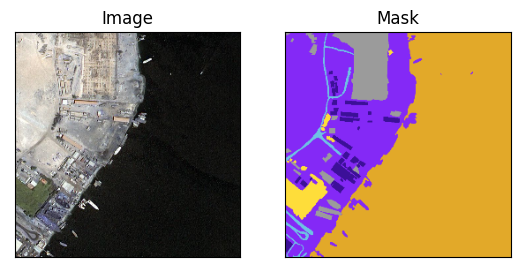

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
rand_index = np.random.randint(low=0, high=images_array.shape[0])
ax1.imshow(images_array[rand_index])
ax1.set_title("Image")
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax2.imshow(masks_array[rand_index])
ax2.set_title("Mask")
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
plt.show()

Split the training and test

In [12]:
x_train, x_test = images_array[:-9], images_array[-9:]
y_train, y_test = masks_array[:-9], masks_array[-9:]

Replace the RGB values in mask with a single scalar

In [13]:
def rgb2scalar(test_arr:np.ndarray, rgb_vals:dict) -> np.ndarray:
    ''' Takes a collection of 3D arrays of RGB values and replaces 
        each 3D array with an int corresponding to a color and 
        returns a collection of 2D arrays '''
    arr_2d = []
    for arr in test_arr:
        conlist = [
            arr == rgb_vals['Building'], 
            arr == rgb_vals['Land'],
            arr == rgb_vals['Road'],
            arr == rgb_vals['Vegetation'],
            arr == rgb_vals['Water'], 
            arr == rgb_vals['Unlabeled']]
        choise_list =[0,1,2,3,4,5]
        zm = np.select(condlist=conlist, choicelist=choise_list, default=5)
        arr_2d.append(zm[:,:,0])
    return np.array(arr_2d)

In [ ]:
def scalar2rgb(arr2d:np.ndarray, rgb_vals:dict) -> np.ndarray:
    pass

In [14]:
y_train_scalar = rgb2scalar(test_arr=y_train, rgb_vals=class_color_RGB)

In [15]:
y_train_scalar.shape

(63, 256, 256)

Try a small model

In [16]:
simple_feature_extractor = Sequential()
simple_feature_extractor.add(Conv2D(filters=32, kernel_size=3, activation='sigmoid', padding='same', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
simple_feature_extractor.add(Conv2D(filters=32, kernel_size=3, activation='sigmoid', padding='same', kernel_initializer='he_uniform'))

In [17]:
simple_X = simple_feature_extractor.predict(x_train)

2/2 [==============================] - 8s 4s/step


In [18]:
simple_X.shape

(63, 256, 256, 32)

In [19]:
X = simple_X.reshape(-1, simple_X.shape[3])

In [20]:
X.shape

(4128768, 32)

In [21]:
Y = y_train_scalar.reshape(-1)
Y.shape

(4128768,)

Ramdom Forest Classifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=20, random_state=42, max_depth=10)
rf_model.fit(X,Y)

X_train $\rightarrow$ (8, 512, 512, 3) after feature extraction X $\rightarrow$ (8, 512, 512, 32)<br>
Reshape X $\rightarrow$ (8 x 512 x 512=2097152, 32)<br>
Y.shape = (2097152,)

x_train and y_train should have the same dimensions

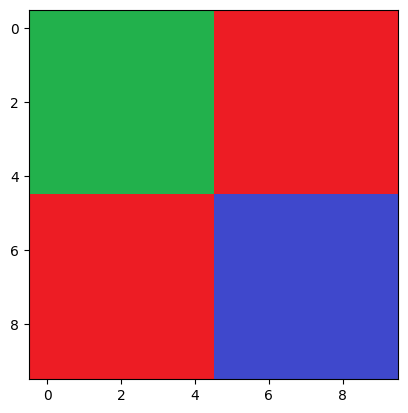

In [23]:
test = cv2.imread('test_img.png', 1)
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)
plt.show()

In [24]:
test.shape

(10, 10, 3)

In [25]:
test[3][6]

array([237,  28,  36], dtype=uint8)

In [26]:
condition_list = [test==[ 34, 177,  76], test==[ 63,  72, 204], test==[237,  28,  36]]
choise_list = [0, 1, 2]
new_mat = np.select(condition_list, choise_list, 3)

In [27]:
condition_list = [new_mat==0, new_mat==1, new_mat==2]
choise_list = [[ 34, 177,  76], [63,  72, 204], [237,  28,  36]]
re_new_mat = np.select(condition_list, choise_list, 3)

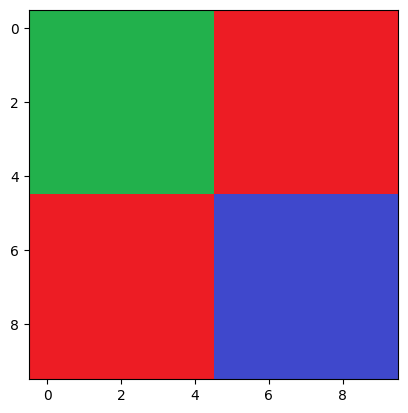

In [28]:
plt.imshow(re_new_mat)
plt.show()

In [29]:
# np.sum([np.all(y_train[0] == class_color_RGB['Building'], axis=-1)])
z_mat = np.zeros(re_new_mat.shape, dtype=np.int32)
z_mat = np.where(re_new_mat==(34,177,76),0, np.where(re_new_mat==(63,72,204), 1, np.where(re_new_mat==(237,28,36),2,-1)))

In [30]:
z_mat.shape

(10, 10, 3)

In [31]:
z_mat[:,:,0].shape

(10, 10)